In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from strategy.functions import *
from CovMex import *
from scipy.stats import hypergeom
from statsmodels.stats import multitest

import seaborn as sns
import pandas as pd

sns.set(rc={'figure.figsize':(7.2,4.45), 
            'mathtext.fontset': 'stix',
            'font.family': ['STIXGeneral'],
            'xtick.labelsize': 16,
            'ytick.labelsize': 16,
            'font.size': 15,
            'figure.autolayout': True,
            'axes.titlesize' : 16,
            'axes.labelsize' : 17,
            'lines.linewidth' : 2,
            'lines.markersize' : 6,
            'legend.fontsize': 13,
            "xtick.bottom" : True, "ytick.left" : True
           })

sns.set_style("ticks")
colourWheel =['#329932',
            '#ff6961',
            'b',
            '#6a3d9a',
            '#fdbf6f',
            '#ff7f00',]

sns.set_palette(colourWheel)



In [3]:
# Load output and reference modules for evaluation
comp_folder = '../out/components/DriveWays/cc_n1173_k3.txt'
pred_modules, mapping = predict_modules(f'{comp_folder}')

ref_folder = '../data/kegg6.2.txt'
ref_modules = txt_parser2(f'{ref_folder}')

covmex = CovMex('../data/gene_patients_Pan-cancer.txt')

## ODMSS

In [4]:
sum_odmss = 0
for pred_m in pred_modules:
    sum_odmss += covmex.getcov(pred_m)* covmex.getmutex(pred_m)
print(f'ODMSS = {sum_odmss}')

ODMSS = 79.39722071867118


## MMR

In [5]:
# MMR for overlap      
edges = []
n_ref, n_pred =len(ref_modules), len(pred_modules)
for i,P in enumerate(pred_modules):
    best_ = 0
    for j,R in enumerate(ref_modules):
        u,v = j, i+len(ref_modules)
        intes = len(set(R).intersection(set(P)))
        w = intes**2/(len(R)*len(P))
        edges.append((u,v,w))
mmr_overlap = get_mmr(edges,n_ref, n_pred)

# MMR for q-value   
M = len(intAct_genes)
pvals = []
for i in range(len(ref_modules)):
    for j in range(len(pred_modules)):
        a = ref_modules[i]
        b = pred_modules[j]
        n = len(a)
        N = len(b)
        x = len(set(a).intersection(set(b)))
        pvals.append(hypergeom.sf(x-1, M, n, N))

qvals = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

edges_pvals = []    
reject = qvals[0]
corr_pvals = qvals[1]

enriched_tuples = {}
for i in range(len(ref_modules)):
    for j in range(len(pred_modules)):
        if reject[i*len(pred_modules) + j] == True:
            w = -np.log10(corr_pvals[i*len(pred_modules) + j])
            edges_pvals.append((j, i+n_pred,w))
            


mmr_qvalue = get_mmr(edges_pvals,n_ref, n_pred)

# MMR for GO consistency
edges_GO_cons_level5 = []
for i in range(len(ref_modules)):
    ref_GO_terms_level5 = set().union(*[set(level5_assocition[g]) for g in ref_modules[i] if g in level5_assocition])
    for j in range(len(pred_modules)):
        pred_GO_terms_level5 = set().union(*[set(level5_assocition[g]) for g in pred_modules[j] if g in level5_assocition])
        if len(set(ref_GO_terms_level5)) == 0:
            w_level5 = 0
        else:
            w_level5 = len(set(ref_GO_terms_level5).intersection(set(pred_GO_terms_level5)))/len(set(ref_GO_terms_level5).union(set(pred_GO_terms_level5)))
        edges_GO_cons_level5.append((j, i+n_pred+1,w_level5))
mmr_GO = get_mmr(edges_GO_cons_level5,n_ref, n_pred)

print(f'MMR scores: \n \t overlap score = {mmr_overlap:.3f} \n \t q-value= {mmr_qvalue:.3f} \n \t GO consistency= {mmr_GO:.3f}')

MMR scores: 
 	 overlap score = 0.060 
 	 q-value= 3.540 
 	 GO consistency= 0.359


## Best Match

/Users/mac/opt/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


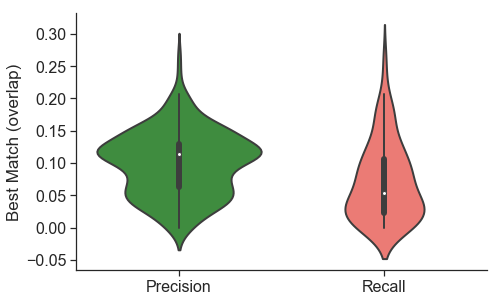

In [6]:
value_arr = []
type_arr = []
n_ref, n_pred =len(ref_modules), len(pred_modules)
scores = overlaps_func(ref_modules,pred_modules)
prec = []
for j, pred_module in  enumerate(pred_modules):
    overlaps = [scores[i*len(pred_modules) + j] for i,ref_module in enumerate(ref_modules)]
    max_ = max(overlaps)
    value_arr.append(max_)
    type_arr.append('Precision')

rec= []
for i, ref_module in  enumerate(ref_modules):
    overlaps = [scores[i*len(pred_modules) + j] for j, pred_module in  enumerate(pred_modules)]
    max_ = max(overlaps)
    value_arr.append(max_)
    type_arr.append('Recall')
            
d = {'Value': value_arr,
     'Type' : type_arr,
}
df = pd.DataFrame(data=d)

ax = sns.violinplot(x="Type", y="Value", data=df,dodge=True,scale="count")
ax.set_ylabel('Best Match (overlap)')
ax.set_xlabel('')
art = [ax.legend]
sns.despine()


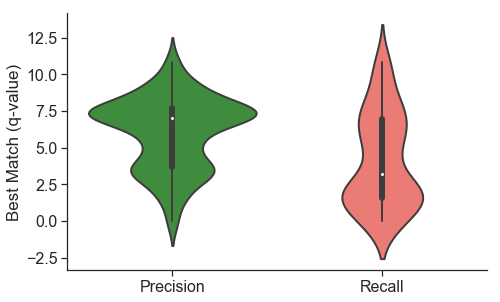

In [7]:
value_arr = []
type_arr = []
n_ref, n_pred =len(ref_modules), len(pred_modules)
scores = -np.log10(qvalues(ref_modules,pred_modules))
prec = []
for j, pred_module in  enumerate(pred_modules):
    overlaps = [scores[i*len(pred_modules) + j] for i,ref_module in enumerate(ref_modules)]
    max_ = max(overlaps)
    value_arr.append(max_)
    type_arr.append('Precision')

rec= []
for i, ref_module in  enumerate(ref_modules):
    overlaps = [scores[i*len(pred_modules) + j] for j, pred_module in  enumerate(pred_modules)]
    max_ = max(overlaps)
    value_arr.append(max_)
    type_arr.append('Recall')
            
d = {'Value': value_arr,
     'Type' : type_arr,
}
df = pd.DataFrame(data=d)

ax = sns.violinplot(x="Type", y="Value", data=df,dodge=True,scale="count")
ax.set_ylabel('Best Match (q-value)')
ax.set_xlabel('')
art = [ax.legend]
sns.despine()


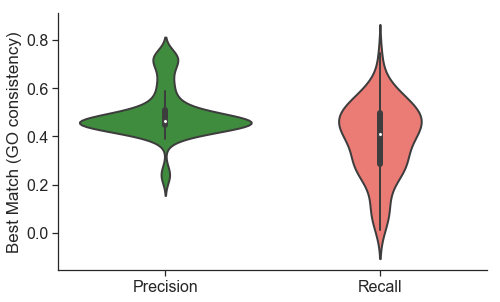

In [8]:
value_arr = []
type_arr = []
n_ref, n_pred =len(ref_modules), len(pred_modules)
scores = GO_Consistency_score(ref_modules,pred_modules)
prec = []
for j, pred_module in  enumerate(pred_modules):
    overlaps = [scores[i*len(pred_modules) + j] for i,ref_module in enumerate(ref_modules)]
    max_ = max(overlaps)
    value_arr.append(max_)
    type_arr.append('Precision')

rec= []
for i, ref_module in  enumerate(ref_modules):
    overlaps = [scores[i*len(pred_modules) + j] for j, pred_module in  enumerate(pred_modules)]
    max_ = max(overlaps)
    value_arr.append(max_)
    type_arr.append('Recall')
            
d = {'Value': value_arr,
     'Type' : type_arr,
}
df = pd.DataFrame(data=d)

ax = sns.violinplot(x="Type", y="Value", data=df,dodge=True,scale="count")
ax.set_ylabel('Best Match (GO consistency)')
ax.set_xlabel('')
art = [ax.legend]
sns.despine()
